In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sbn 

import statsmodels.api as sm
from statsmodels.formula.api import ols, logit

import os 

# Aggregate results

The results of the sensitivity analysis (outputs of running ```$ python HER2_sensitivity_runs.sh```) are saved in the realative path `OUT_DIR`, which will need to be manually set in the next cell. The results of each analysis (with different hyper parameters) will be aggregated into final dataframes for use in making final resistance/sensitivity calls. If there are questions or concerns with any specific set of hyper-parameters, the figures out output files are available for inspection. 

In [2]:
OUT_DIR = './trastuzumab_output/'
CSV_OUT = './trastuzumab_SKBR3_results.csv'

df = [] 
df2 = []
for run in os.listdir(OUT_DIR): 
    run_res_path = OUT_DIR + run + '/run_results.csv'
    if os.path.exists(run_res_path): 
        df.append( pd.read_csv(run_res_path) ) 
    else: 
        print(f'Directory not found! run id: {run}')
        
    prob_res_path = OUT_DIR + run + '/unlabeled_lines_results.csv' 
    if os.path.exists(prob_res_path): 
        prob_res = pd.read_csv(prob_res_path).assign(run_id=run)
        df2.append(prob_res)
        
run_res = pd.concat(df, axis=0, ignore_index=True)
prob_res = pd.concat(df2, axis=0, ignore_index=True).rename({'Unnamed: 0':'obs_id'}, axis=1)
prob_res.head()

,obs_id,pc1,pc2,treatment,mutant,exp_set,prob_res,prob_sens,call,odds_ratio,batch,PC1_batch_pval,PC1_batch_flag,PC2_batch_pval,PC2_batch_flag,drug,cell_track_count,low_data_flag,run_id
0,0,-0.219578,0.041826,trastuzumab,V797A,H210401_Set1,0.136213,0.863787,sens,0.157692,H210401_Set1,0.023620,True,0.006703,True,trastuzumab,79,False,024e5d1d-92e1-4c8b-90f7-bce3ee413891
1,1,-0.172534,0.023163,trastuzumab,H470Q,H210219_Set2,0.141030,0.858970,sens,0.164185,H210219_Set2,0.618214,False,0.106543,False,trastuzumab,141,False,024e5d1d-92e1-4c8b-90f7-bce3ee413891
2,2,-0.263707,0.056752,trastuzumab,A355QFS76,H210423_Set1,0.161731,0.838269,sens,0.192935,H210423_Set1,0.497710,False,0.014023,True,trastuzumab,128,False,024e5d1d-92e1-4c8b-90f7-bce3ee413891
3,3,-0.140141,0.019743,trastuzumab,E975Q,H210326_Set2,0.162297,0.837703,sens,0.193740,H210326_Set2,0.815237,False,0.009231,True,trastuzumab,36,False,024e5d1d-92e1-4c8b-90f7-bce3ee413891
4,4,-0.271472,0.152687,trastuzumab,M889I,H210326_Set2,0.177432,0.822568,sens,0.215706,H210326_Set2,0.815237,False,0.009231,True,trastuzumab,11,False,024e5d1d-92e1-4c8b-90f7-bce3ee413891


In [3]:
run_res.head()

,Unnamed: 0,accuracy(train),pc1_var,pc2_var,kmeans_inertia,res_line,sens_line,drug,nclus,resample_sz,load,burnin,run_id
0,0,0.884615,0.463324,0.264398,4.315772,ND611,WT,trastuzumab,5,100,normalized,0,024e5d1d-92e1-4c8b-90f7-bce3ee413891
1,0,0.961538,0.297039,0.183754,4.340578,ND611,WT,trastuzumab,20,125,raw,5,02b57be0-be3c-43de-aef7-9ea2bb7baf63
2,0,0.923077,0.282494,0.192720,4.327057,ND611,WT,trastuzumab,20,125,normalized,0,039bae68-4d5a-4aec-b1c5-befa04cabbb9
3,0,0.923077,0.484281,0.276201,5.446018,ND611,WT,trastuzumab,5,125,raw,5,03cec5f9-3acb-439c-858e-9ff65faaef82
4,0,0.923077,0.478690,0.262728,5.554802,ND611,WT,trastuzumab,5,125,raw,0,03eceff7-c5a0-4f46-a4a2-aa429266924a


In [4]:
exp_params = run_res[['nclus', 'resample_sz', 'load', 'burnin']].drop_duplicates()
all_data = prob_res.merge(run_res, on='run_id')

--- 

# Summary

In [5]:
print('# of experiment hyper-parameters tested:', len(exp_params))
print('# of mutants:', prob_res.mutant.unique().shape[0])
print('# of experiments:', prob_res.exp_set.unique().shape[0])
print(f'# of treatments: {prob_res.treatment.unique().shape[0]} [{prob_res.treatment.unique()}]')

# of experiment hyper-parameters tested: 90
# of mutants: 83
# of experiments: 13
# of treatments: 1 [['trastuzumab']]


---

# Batch effect flags 

Each analysis will assign two batch effect flags (for PC1 & PC2, independantly). This is done by running a regression to predict  the respective principle component from the experiment set (controls only); If the subsequent ANOVA shows a significant experiment set coefficient (p-val less that 0.05), than the flag is set. 

In [6]:
# test if any hyperparameters are predictive of low batch effect p-values. 
lm = ols('PC1_batch_pval ~ nclus + resample_sz + load + burnin', data=all_data).fit(maxiter=50) #Specify C for Categorical
print( lm.summary() )

                            OLS Regression Results                            
Dep. Variable:         PC1_batch_pval   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     168.2
Date:                Thu, 08 Jul 2021   Prob (F-statistic):          3.21e-143
Time:                        10:40:10   Log-Likelihood:                -6938.1
No. Observations:               45000   AIC:                         1.389e+04
Df Residuals:                   44995   BIC:                         1.393e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.4260      0.007     58.098      

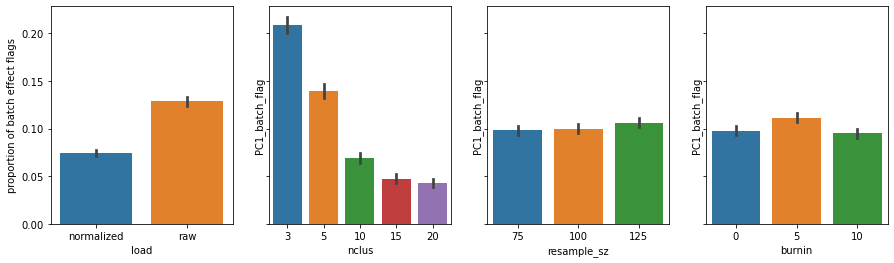

<Figure size 432x288 with 0 Axes>

In [7]:
f, axes = plt.subplots(1,4, figsize = (15,4), sharey=True)

plt.figure()
sbn.barplot(x='load', y='PC1_batch_flag', data=all_data, ax=axes.flat[0])
axes.flat[0].set_ylabel('proportion of batch effect flags')
sbn.barplot(x='nclus', y='PC1_batch_flag', data=all_data, ax=axes.flat[1])
sbn.barplot(x='resample_sz', y='PC1_batch_flag', data=all_data, ax=axes.flat[2])
sbn.barplot(x='burnin', y='PC1_batch_flag', data=all_data, ax=axes.flat[3])
plt.show()

In [8]:
lm = ols('PC2_batch_pval ~ nclus + resample_sz + load + burnin', data=all_data).fit(maxiter=50) #Specify C for Categorical
print( lm.summary() )

                            OLS Regression Results                            
Dep. Variable:         PC2_batch_pval   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     662.5
Date:                Thu, 08 Jul 2021   Prob (F-statistic):               0.00
Time:                        10:40:12   Log-Likelihood:                -6461.7
No. Observations:               45000   AIC:                         1.293e+04
Df Residuals:                   44995   BIC:                         1.298e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.4273      0.007     58.902      

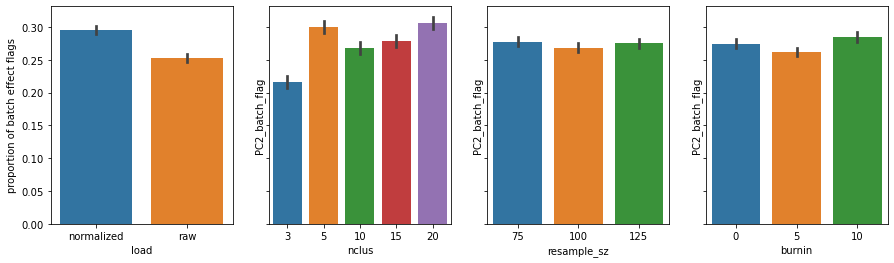

<Figure size 432x288 with 0 Axes>

In [9]:
f, axes = plt.subplots(1,4, figsize = (15,4), sharey=True)

plt.figure()
sbn.barplot(x='load', y='PC2_batch_flag', data=all_data, ax=axes.flat[0])
axes.flat[0].set_ylabel('proportion of batch effect flags')
sbn.barplot(x='nclus', y='PC2_batch_flag', data=all_data, ax=axes.flat[1])
sbn.barplot(x='resample_sz', y='PC2_batch_flag', data=all_data, ax=axes.flat[2])
sbn.barplot(x='burnin', y='PC2_batch_flag', data=all_data, ax=axes.flat[3])
plt.show()

## Did any one experiment have high batch effect flag proportions? 

In [10]:
# computing the average # of flags within each set + avg cell # of cell tracks 
# e.g., value of 0.14 for PC1_batch_flag below indicates that 14% of single analysis runs assigned a batch effect for PC1 in that experiment set. 
all_data.groupby('exp_set')[['low_data_flag', 'PC1_batch_flag', 'PC2_batch_flag', 'cell_track_count']].mean()

,low_data_flag,PC1_batch_flag,PC2_batch_flag,cell_track_count
exp_set,,,,
H210205_Set1_2,0.0,0.000000,0.000000,230.875000
H210205_Set2_2,0.0,0.000000,0.000000,299.000000
H210212_Set1,0.0,0.257778,0.144444,242.142857
H210212_Set2,0.0,0.195556,0.015556,207.750000
H210219_Set1,0.0,0.000000,0.000000,289.428571
H210219_Set2,0.0,0.000000,0.075556,253.125000
H210326_Set1,0.0,0.000000,0.633333,186.000000
H210326_Set2,0.0,0.000000,0.735556,201.750000
H210401_Set1,0.0,0.633333,0.993333,237.571429


# Low Data Flag 

Lowe data flags are set if any group (cell line, mutant, treatment) has less than 5% of the median number of cell tracks. 

In [11]:
prob_res[['mutant', 'low_data_flag']].low_data_flag.any()

False

# Train accuracy 

This quantifies how well the controls (resistant mutant and sensitive mutant under treatment) separate in PC-space. Poor training accuracy indicates that the analysis had a difficult time distinguishing sensitive response from resistant response, and so it's important to understand if any hyper parameters contribute to the separability. 

In [12]:
lm = ols('accuracy ~ nclus + resample_sz + load', data=run_res.rename({'accuracy(train)':'accuracy'}, axis=1)).fit() #Specify C for Categorical
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     31.47
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           1.82e-18
Time:                        10:40:14   Log-Likelihood:                 906.76
No. Observations:                 450   AIC:                            -1806.
Df Residuals:                     446   BIC:                            -1789.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.8963      0.008    109.241      

# Concordant sensitive/resistance probabilities 

To examine the stability of the predicted probabilities **across replicates** (e.g., between analysis with different hyper-parameters), we can examine the clustered heatmap of predicted resistance probabilities. High positive correlation indicates that pairwise predicted probability between two analysis runs were the same or similar. *Negative correlation, or no correlation would indicate contridictory probability predictions.* 

/home/teddy/miniconda3/envs/HER2/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


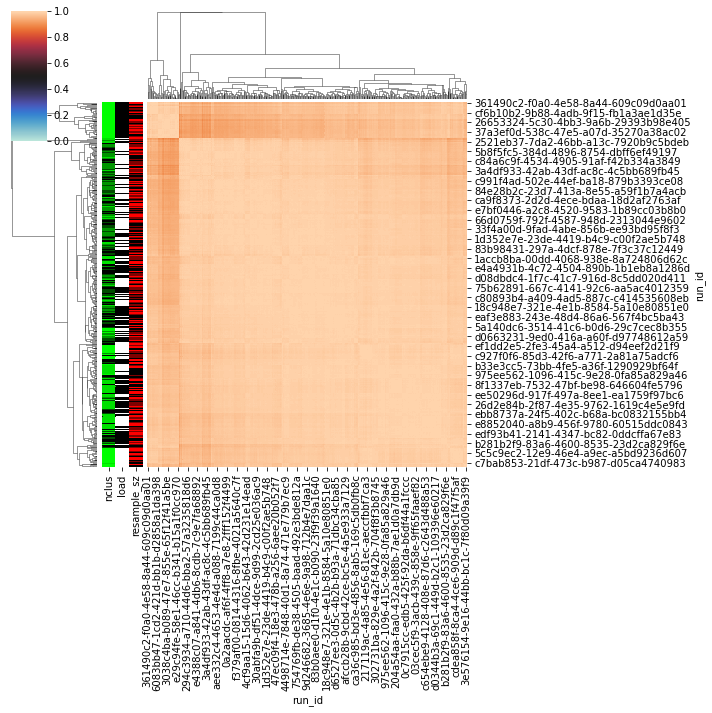

In [13]:
norm = lambda x, y: (x-min(y))/ (max(y) - min(y)) 

nclus_ = {row.run_id:[0., 1- norm(row.nclus,run_res.nclus),0., 0.5] for i,row in run_res.iterrows()}
nclus_colors = run_res['run_id'].map(nclus_).rename('nclus')

load_ = {row.run_id:'k' if (row.load == 'normalized') else 'w' for i,row in run_res.iterrows()}
load_colors = run_res['run_id'].map(load_).rename('load')

resamp_ = {row.run_id:[1 - norm(row.resample_sz,run_res.resample_sz), 0., 0., 0.5] for i,row in run_res.iterrows()}
resamp_colors = run_res['run_id'].map(resamp_).rename('resample_sz')

row_colors = pd.concat([nclus_colors, load_colors, resamp_colors], axis=1)
row_colors = row_colors.set_index(run_res.run_id)

#print(row_colors)

#ids_tokeep = run_res[lambda x: (x.nclus < 35)].run_id.values
#prob_res2 = prob_res[lambda x: x.run_id.isin(ids_tokeep)]

prob_res2 = prob_res.merge(run_res, on='run_id').pivot(columns='run_id', index='obs_id', values='prob_res')
res_mat = prob_res2.corr().fillna(0)
sbn.clustermap(res_mat, vmin=0, vmax=1, center=0.5, row_colors=row_colors, figsize=(10,10))

# Consensus Probability/Resistance Calls 

Using the results of all analysis runs (with different configurations) we can assign sens/res labels based on the consensus calls. 

In [37]:
conc_calls = prob_res.groupby(['mutant', 'call']).count()[['run_id']].reset_index().set_index('mutant') \
                    .pivot(columns='call', values='run_id').fillna(value=0) \
                    .assign(prop_call_res=lambda x: x.res / (x.res + x.sens + x['no-call']))\
                    .assign(prop_call_sens=lambda x: x.sens / (x.res + x.sens + x['no-call']))\
                    .assign(prop_call_nocall=lambda x: x['no-call'] / (x.res + x.sens + x['no-call']))

conc_calls = conc_calls.merge(prob_res[['mutant', 'cell_track_count', 'low_data_flag']].drop_duplicates(), on='mutant')
conc_calls = conc_calls.merge(prob_res[['mutant', 'PC1_batch_flag', 'PC2_batch_flag']].groupby('mutant').agg('mean').reset_index())
conc_calls = conc_calls.rename({'PC1_batch_flag': 'prop_PC1_batch_flag', 'PC2_batch_flag': 'prop_PC2_batch_flag'}, axis=1)

In [38]:
# should be (83, 10)
conc_calls.shape

(83, 11)

In [39]:
# should have no na's (e.g., empty is good)
conc_calls[conc_calls.isna().values.any(axis=1)]

,mutant,no-call,res,sens,prop_call_res,prop_call_sens,prop_call_nocall,cell_track_count,low_data_flag,prop_PC1_batch_flag,prop_PC2_batch_flag


In [40]:
# 90 single-analysis runs * 5 replicats = 450 
# some mutants were run twice 
# ND611/T798I/WT are run with every experiment (90*5*13 experiments = 5850)
conc_calls[['no-call', 'res', 'sens']].sum(axis=1).unique()

array([ 450.,  900., 5850.])

In [41]:
# save concordant calls to file 
conc_calls.to_csv(CSV_OUT)

## Sorted by proportion of calls made as `resistant`

In [42]:
conc_calls.sort_values('prop_call_res', ascending=False).head(10)

,mutant,no-call,res,sens,prop_call_res,prop_call_sens,prop_call_nocall,cell_track_count,low_data_flag,prop_PC1_batch_flag,prop_PC2_batch_flag
0,A1039T,0.0,450.0,0.0,1.0,0.0,0.0,125,False,0.000000,0.735556
70,T862A,0.0,450.0,0.0,1.0,0.0,0.0,35,False,0.200000,0.537778
55,R456C,0.0,450.0,0.0,1.0,0.0,0.0,83,False,0.195556,0.015556
75,V842I,0.0,900.0,0.0,1.0,0.0,0.0,257,False,0.100000,0.268889
58,R897G,0.0,450.0,0.0,1.0,0.0,0.0,62,False,0.000000,0.115556
60,S305C,0.0,450.0,0.0,1.0,0.0,0.0,34,False,0.000000,0.633333
7,D769H,0.0,450.0,0.0,1.0,0.0,0.0,33,False,0.200000,0.537778
8,D769N,0.0,450.0,0.0,1.0,0.0,0.0,84,False,0.000000,0.115556
68,T733I,0.0,450.0,0.0,1.0,0.0,0.0,110,False,0.000000,0.000000
34,L755T759DEL,0.0,450.0,0.0,1.0,0.0,0.0,131,False,0.000000,0.000000


## Sorted by proportion of calls made as `sensitive`

In [43]:
conc_calls.sort_values('prop_call_sens', ascending=False).head(10)

,mutant,no-call,res,sens,prop_call_res,prop_call_sens,prop_call_nocall,cell_track_count,low_data_flag,prop_PC1_batch_flag,prop_PC2_batch_flag
1,A1160V,0.0,0.0,450.0,0.0,1.000000,0.000000,66,False,0.000000,0.002222
44,P416T,0.0,0.0,450.0,0.0,1.000000,0.000000,43,False,0.195556,0.015556
12,E405D,0.0,0.0,450.0,0.0,1.000000,0.000000,59,False,0.091111,0.328889
49,R1153L,0.0,0.0,450.0,0.0,1.000000,0.000000,102,False,0.000000,0.115556
72,V424I,0.0,0.0,450.0,0.0,1.000000,0.000000,187,False,0.000000,0.000000
74,V797A,0.0,0.0,450.0,0.0,1.000000,0.000000,79,False,0.633333,0.993333
54,R34W,1.0,0.0,449.0,0.0,0.997778,0.002222,100,False,0.633333,0.993333
46,P579L,1.0,0.0,449.0,0.0,0.997778,0.002222,136,False,0.091111,0.328889
2,A355QFS76,4.0,0.0,896.0,0.0,0.995556,0.004444,128,False,0.100000,0.268889
80,Y64F,3.0,0.0,447.0,0.0,0.993333,0.006667,189,False,0.000000,0.000000


## Sorted by proportion of calls made as `no-call`

In [44]:
conc_calls.sort_values('prop_call_nocall', ascending=False).head(5)

,mutant,no-call,res,sens,prop_call_res,prop_call_sens,prop_call_nocall,cell_track_count,low_data_flag,prop_PC1_batch_flag,prop_PC2_batch_flag
20,G309A,240.0,79.0,131.0,0.175556,0.291111,0.533333,36,False,0.200000,0.537778
30,L313V,191.0,52.0,207.0,0.115556,0.460000,0.424444,42,False,0.000000,0.000000
79,Y1127A1129DEL,188.0,75.0,187.0,0.166667,0.415556,0.417778,78,False,0.000000,0.115556
56,R47C,178.0,108.0,164.0,0.240000,0.364444,0.395556,121,False,0.195556,0.015556
63,S609C,172.0,137.0,141.0,0.304444,0.313333,0.382222,85,False,0.000000,0.000000


In [45]:
conc_calls.sort_values('prop_PC1_batch_flag', ascending=False).head(5)

,mutant,no-call,res,sens,prop_call_res,prop_call_sens,prop_call_nocall,cell_track_count,low_data_flag,prop_PC1_batch_flag,prop_PC2_batch_flag
64,S963,4.0,0.0,446.0,0.000000,0.991111,0.008889,40,False,0.633333,0.993333
81,Y722V773INSRDGE,18.0,0.0,432.0,0.000000,0.960000,0.040000,60,False,0.633333,0.993333
54,R34W,1.0,0.0,449.0,0.000000,0.997778,0.002222,100,False,0.633333,0.993333
59,R929W,144.0,293.0,13.0,0.651111,0.028889,0.320000,108,False,0.633333,0.993333
74,V797A,0.0,0.0,450.0,0.000000,1.000000,0.000000,79,False,0.633333,0.993333


In [46]:
conc_calls.sort_values('prop_PC2_batch_flag', ascending=False).head(5)

,mutant,no-call,res,sens,prop_call_res,prop_call_sens,prop_call_nocall,cell_track_count,low_data_flag,prop_PC1_batch_flag,prop_PC2_batch_flag
64,S963,4.0,0.0,446.0,0.000000,0.991111,0.008889,40,False,0.633333,0.993333
74,V797A,0.0,0.0,450.0,0.000000,1.000000,0.000000,79,False,0.633333,0.993333
81,Y722V773INSRDGE,18.0,0.0,432.0,0.000000,0.960000,0.040000,60,False,0.633333,0.993333
29,L1197F,137.0,118.0,195.0,0.262222,0.433333,0.304444,126,False,0.633333,0.993333
59,R929W,144.0,293.0,13.0,0.651111,0.028889,0.320000,108,False,0.633333,0.993333


## Distribution of concordant resistance calls 

X-axis indicates the proportion of resistance calls made for a given mutant, and y-axis indicates the number of mutants in that range.

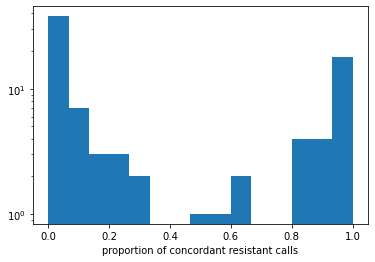

In [47]:
plt.figure()
plt.hist(conc_calls.prop_call_res, bins=15)
plt.yscale('log')
plt.xlabel('proportion of concordant resistant calls')
plt.show()

In [48]:
np.sum( conc_calls.prop_call_res > 0.75 )

26

In [49]:
# Most resistant mutants 
conc_res_obs_ids = conc_calls[conc_calls.prop_call_res > 0.75].reset_index().mutant.values
conc_res_obs_ids

array(['A1039T', 'A37T', 'D638H', 'D639E', 'D769H', 'D769N', 'D769Y',
       'D873G', 'D933Y', 'E717K', 'E939G', 'G727A', 'G778S779INSLPS',
       'I767M', 'L755S', 'L755T759DEL', 'L869R', 'N427K', 'R456C',
       'R897G', 'S305C', 'T733I', 'T798I', 'T862A', 'T862S', 'V842I'],
      dtype=object)

# Cell track correlation with resistance

One element to investigate as a potential confounding factor is how the number of cell tracks in a given group (cell line, mutant, treatment) correlates to the final assigned proportion of resistant calls. 

In [27]:
lm = ols('prop_call_res ~ cell_track_count', data=conc_calls[conc_calls.cell_track_count < 500]).fit(maxiter=50) #Specify C for Categorical
print( lm.summary() )

                            OLS Regression Results                            
Dep. Variable:          prop_call_res   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.2064
Date:                Thu, 08 Jul 2021   Prob (F-statistic):              0.651
Time:                        10:40:17   Log-Likelihood:                -45.509
No. Observations:                  82   AIC:                             95.02
Df Residuals:                      80   BIC:                             99.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3157      0.095  

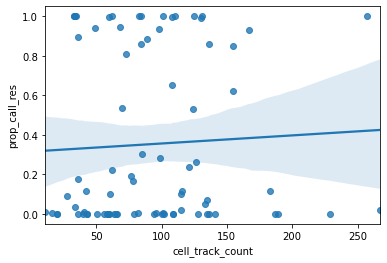

In [28]:
plt.figure()
sbn.regplot(x='cell_track_count', y='prop_call_res', data=conc_calls[conc_calls.cell_track_count < 500])
plt.show()

# Model variance 

To investigate if replicates produce similar or concordant results. (e.g., same data, same hyper params, different inital conditions or seeds) 

In [29]:
def get_model_variance_stats(nclus, load, sz): 
    
    _ids = run_res[lambda x: (x.nclus==nclus) & (x.load == load) & (x.resample_sz == sz)].run_id
    mvar_ = prob_res[lambda x: x.run_id.isin(_ids)]
    mvar_res = mvar_[['run_id', 'obs_id', 'prob_res']].pivot(columns='run_id', values='prob_res', index='obs_id')
    mvar_mat = mvar_res.corr()

    triu_idx = np.triu_indices(mvar_mat.shape[0], k=1)
    corrs = mvar_mat.values[triu_idx]
    corr_mean = corrs.mean()
    corr_std = corrs.std()
    corr_min = corrs.min()
    corr_max = corrs.max()
    return corr_mean, corr_std, corr_min, corr_max

var_res = {'nclus':[], 'load':[], 'resample_sz':[], 'corr_mean':[], 'corr_std':[], 'corr_min':[], 'corr_max':[]}
for nc in run_res.nclus.unique(): 
    for l in run_res.load.unique(): 
        for sz in run_res.resample_sz.unique(): 
            corr_mean, corr_std, corr_min, corr_max = get_model_variance_stats(nc, l, sz)
            var_res['nclus'].append(nc)
            var_res['load'].append(l)
            var_res['resample_sz'].append(sz)
            var_res['corr_mean'].append(corr_mean)
            var_res['corr_std'].append(corr_std)
            var_res['corr_min'].append(corr_min)
            var_res['corr_max'].append(corr_max)
            
var_res = pd.DataFrame(var_res).assign(corr_min_unit = lambda x: x.corr_min.clip(0,1))
var_res.head()

,nclus,load,resample_sz,corr_mean,corr_std,corr_min,corr_max,corr_min_unit
0,5,normalized,100,0.990398,0.013406,0.945022,0.999817,0.945022
1,5,normalized,125,0.993131,0.010788,0.954103,0.999979,0.954103
2,5,normalized,75,0.991286,0.009389,0.964270,0.999990,0.964270
3,5,raw,100,0.992884,0.008324,0.960853,0.999934,0.960853
4,5,raw,125,0.993663,0.006555,0.964248,0.999909,0.964248


In [30]:
lm = logit('corr_min_unit ~ nclus + resample_sz + load', data=var_res).fit() #Specify C for Categorical
print(lm.params)
print()
print(lm.conf_int())
#print()
#print(sm.stats.anova_lm(lm))

Optimization terminated successfully.
         Current function value: 0.036839
         Iterations 8
Intercept      3.012874
load[T.raw]    0.063151
nclus          0.012234
resample_sz    0.003254
dtype: float64

                    0          1
Intercept   -8.199604  14.225353
load[T.raw] -4.170614   4.296915
nclus       -0.328323   0.352791
resample_sz -0.100561   0.107069


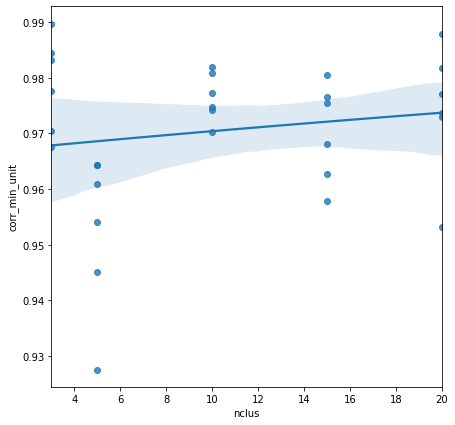

In [31]:
plt.figure(figsize=(7,7))
sbn.regplot(x='nclus', y='corr_min_unit', data=var_res, logistic=True)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

No handles with labels found to put in legend.


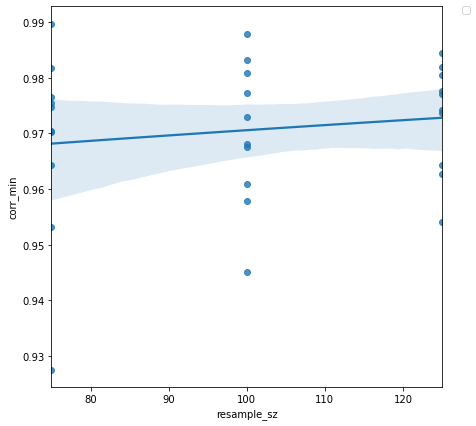

In [32]:
plt.figure(figsize=(7,7))
sbn.regplot(x='resample_sz', y='corr_min', data=var_res, logistic=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

No handles with labels found to put in legend.


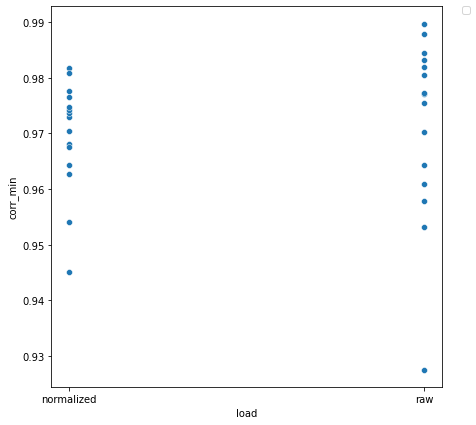

In [33]:
plt.figure(figsize=(7,7))
sbn.scatterplot(x='load', y='corr_min', data=var_res)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Stable Configs


In [34]:
var_res.head()

,nclus,load,resample_sz,corr_mean,corr_std,corr_min,corr_max,corr_min_unit
0,5,normalized,100,0.990398,0.013406,0.945022,0.999817,0.945022
1,5,normalized,125,0.993131,0.010788,0.954103,0.999979,0.954103
2,5,normalized,75,0.991286,0.009389,0.964270,0.999990,0.964270
3,5,raw,100,0.992884,0.008324,0.960853,0.999934,0.960853
4,5,raw,125,0.993663,0.006555,0.964248,0.999909,0.964248


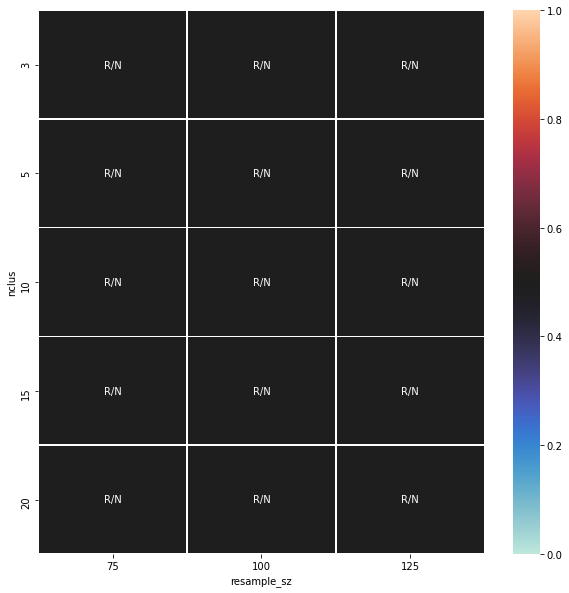

In [35]:
var_res2 = var_res[lambda x: x.corr_min > 0.85][['resample_sz', 'nclus', 'load']].groupby(['resample_sz', 'nclus']).agg('-'.join).reset_index()
var_mat = var_res2.assign(load= [0 if x=='raw' else (1 if x=='normalized' else 0.5) for x in var_res2.load])
labels = var_res2.assign(load= ['R' if x=='raw' else ('N' if x=='normalized' else 'R/N') for x in var_res2.load]).pivot(columns='resample_sz', index='nclus', values='load')
var_mat = var_mat.pivot(columns='resample_sz', index='nclus', values='load')

plt.figure(figsize=(10,10))
sbn.heatmap(var_mat, linewidths=.5, annot=labels.values, fmt='', vmin=0, vmax=1, center=0.5)
plt.show()

In [36]:
hi_ac = run_res.groupby(['nclus', 'resample_sz', 'load']).agg('mean')[['accuracy(train)']][lambda x: x['accuracy(train)'] == 1.]

hi_ac = hi_ac.reset_index()[['nclus', 'resample_sz', 'load']].groupby(['resample_sz', 'nclus']).agg('-'.join).reset_index()

acc_mat = hi_ac.assign(load= [0 if x=='raw' else (1 if x=='normalized' else 0.5) for x in hi_ac.load]).pivot(columns='resample_sz', index='nclus', values='load')
labels = hi_ac.assign(load= ['R' if x=='raw' else ('N' if x=='normalized' else 'R/N') for x in hi_ac.load]).pivot(columns='resample_sz', index='nclus', values='load')

plt.figure(figsize=(10,10))
sbn.heatmap(acc_mat, linewidths=.5, annot=labels.values, fmt='', vmin=0, vmax=1, center=0.5)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'load'